In [4]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from jax import vmap, value_and_grad
import optax
import jaxopt
import enlighten
import os
import scipy
import matplotlib as mpl
import pandas as pd
import glob


from NNmodels import MLP, MLP_init_params, glorot_normal, MSE

In [5]:
# check for devices - if gpu available
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
devices = jax.local_devices()
print(devices)

[CudaDevice(id=0)]


In [6]:
folder_path = '/home/houtlaw/iono-net/data/SAR_AF_ML_toyDataset_etc/radar_series_csv'

# Pattern to match files like 'storedPsi_seedxx_20241004_140801.csv'
pattern = glob.glob(os.path.join(folder_path, 'storedPsi_seed[0-9]*_[0-9]*_[0-9]*.csv'))

data_df = pd.read_csv(pattern[0])


# is this right???


# Iterate over the matching files
for (i, file_path) in enumerate(pattern[1:]):
    print(f"Processing file: {file_path}")
    data_df = pd.concat([data_df, pd.read_csv(file_path)["Val"]], axis = 1)

data_df

Processing file: /home/houtlaw/iono-net/data/SAR_AF_ML_toyDataset_etc/radar_series_csv/storedPsi_seed714_20241004_154043.csv
Processing file: /home/houtlaw/iono-net/data/SAR_AF_ML_toyDataset_etc/radar_series_csv/storedPsi_seed565_20241004_153652.csv
Processing file: /home/houtlaw/iono-net/data/SAR_AF_ML_toyDataset_etc/radar_series_csv/storedPsi_seed254_20241004_152850.csv
Processing file: /home/houtlaw/iono-net/data/SAR_AF_ML_toyDataset_etc/radar_series_csv/storedPsi_seed572_20241004_153703.csv
Processing file: /home/houtlaw/iono-net/data/SAR_AF_ML_toyDataset_etc/radar_series_csv/storedPsi_seed237_20241004_152823.csv
Processing file: /home/houtlaw/iono-net/data/SAR_AF_ML_toyDataset_etc/radar_series_csv/storedPsi_seed548_20241004_153626.csv
Processing file: /home/houtlaw/iono-net/data/SAR_AF_ML_toyDataset_etc/radar_series_csv/storedPsi_seed973_20241004_154724.csv
Processing file: /home/houtlaw/iono-net/data/SAR_AF_ML_toyDataset_etc/radar_series_csv/storedPsi_seed335_20241004_153055.csv


,Arg,Val,Val,Val,Val,Val,Val,Val,Val,Val,...,Val,Val,Val,Val,Val,Val,Val,Val,Val,Val
0,0.000,5.070887,0.346656,-1.275788,-1.839597,4.969177,5.638191,-2.400131,0.167525,0.206858,...,3.723868,-1.304575,1.606411,6.543543,-1.764048,-3.481074,-0.774100,0.924196,-1.554645,2.361894
1,0.125,4.972773,0.375447,-1.291039,-1.917579,4.861669,5.741678,-2.422625,0.029331,0.142654,...,3.695618,-1.180795,1.550411,6.473997,-1.726336,-3.527546,-0.704922,1.002854,-1.459590,2.386009
2,0.250,4.874308,0.404669,-1.307208,-1.995819,4.753900,5.844057,-2.444107,-0.107713,0.077362,...,3.665635,-1.056019,1.494258,6.402873,-1.688667,-3.574525,-0.638119,1.081220,-1.364426,2.409563
3,0.375,4.775513,0.434293,-1.324368,-2.074269,4.645914,5.945246,-2.464602,-0.243482,0.010930,...,3.633974,-0.930271,1.437877,6.330283,-1.651017,-3.621981,-0.573617,1.159244,-1.269199,2.432539
4,0.500,4.676411,0.464296,-1.342587,-2.152874,4.537748,6.045160,-2.484138,-0.377853,-0.056685,...,3.600694,-0.803575,1.381193,6.256342,-1.613363,-3.669879,-0.511333,1.236873,-1.173957,2.454924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2876,359.500,-5.068413,3.408324,-3.395579,-4.787970,-5.469997,-4.031504,-3.708141,-3.004935,-3.857201,...,-7.210726,2.098203,-3.672438,-4.089537,5.589135,-1.947742,3.770113,1.257045,2.941658,-0.068312
2877,359.625,-5.070607,3.335772,-3.333217,-4.760018,-5.437637,-4.055702,-3.599264,-2.905847,-3.840182,...,-7.227641,2.061272,-3.540234,-4.079142,5.550989,-1.865260,3.724991,1.176499,2.862746,-0.158798
2878,359.750,-5.072167,3.262126,-3.271123,-4.728701,-5.404378,-4.077869,-3.488394,-2.806183,-3.822830,...,-7.242038,2.026671,-3.408004,-4.069452,5.512710,-1.779909,3.680988,1.096029,2.784375,-0.249186
2879,359.875,-5.073021,3.187399,-3.209355,-4.693994,-5.370212,-4.098050,-3.375630,-2.706030,-3.805138,...,-7.253854,1.994378,-3.275863,-4.060448,5.474422,-1.691722,3.638161,1.015580,2.706666,-0.339471


In [7]:
trk_sensor_pts = data_df["Arg"].to_numpy().reshape(-1, 1)

trk_targets = data_df.drop(columns = ["Arg"]).to_numpy()
print(trk_sensor_pts.shape)
print(trk_targets.shape)

(2881, 1)
(2881, 1000)


In [26]:
np.linalg.matrix_rank(trk_targets)

12

In [8]:
# training config dict
tr_config = {
    "lr_0" : 0.001,              # Initial learning rate for the optimizer
    "lr_gamma": 0.95,            # Learning rate decay factor (multiplies the learning rate by this value at each step)
    "lr_step" : 1000,            # Number of iterations after which the learning rate is updated (decayed)
    "lr_f" : 1e-5,               # Final learning rate (smallest allowed learning rate after decay)
    "maxiter_adam" : 10000,       # Maximum number of iterations for the Adam optimizer
    "maxiter_lbfgs": 1000,       # Maximum number of iterations for the L-BFGS optimizer
    "deepOnet_width" : 12,       # Width of the hidden layers in the DeepONet model (number of neurons per layer)
    "trunk_architecture" : [50, 30, 10],  # Architecture of the trunk network, with 3 layers each containing 50 neurons
    "trunk_activation": jnp.tanh, # Activation function used in the trunk network (tanh in this case)
    "trunk_input_dim": 1,        # Input dimension for the trunk network
    "trunk_output_dim": 1,       # Output dimension for the trunk network
    "trunk_sensor": 2881,         # Number of sensors (inputs) for the trunk network
    "num_train": 1000,             # Number of training samples
    "num_test": 300                # Number of test samples
}




In [9]:
""" # Data preparation

# trk_sensor_pts: Sensor points for the trunk network
# Randomly generates points uniformly in the range [0, 1]
# Shape: (number of sensors, trunk input dimension)
trk_sensor_pts = np.random.uniform(0, 1, (tr_config['trunk_sensor'], tr_config['trunk_input_dim']))

# Loop through the number of training samples
for i in range(tr_config['num_train']):
    w = (i + 1) / tr_config['num_train']  # Weighting factor based on the current sample index

    if i == 0:
        # Initialize the target values for the first training sample
        # trk_targets: Sine values of the weighted sensor points (first target)
        # Shape: (number of sensors, trunk input dimension)
        trk_targets = np.sin(np.pi * w * trk_sensor_pts)
    else:
        # Concatenate the sine values for subsequent training samples along the second axis (column-wise)
        # Expands the targets matrix to include all training samples
        # Axis 1 means concatenate along columns
        trk_targets = np.concatenate([trk_targets, np.sin(np.pi * w * trk_sensor_pts)], axis=1) """


" # Data preparation\n\n# trk_sensor_pts: Sensor points for the trunk network\n# Randomly generates points uniformly in the range [0, 1]\n# Shape: (number of sensors, trunk input dimension)\ntrk_sensor_pts = np.random.uniform(0, 1, (tr_config['trunk_sensor'], tr_config['trunk_input_dim']))\n\n# Loop through the number of training samples\nfor i in range(tr_config['num_train']):\n    w = (i + 1) / tr_config['num_train']  # Weighting factor based on the current sample index\n\n    if i == 0:\n        # Initialize the target values for the first training sample\n        # trk_targets: Sine values of the weighted sensor points (first target)\n        # Shape: (number of sensors, trunk input dimension)\n        trk_targets = np.sin(np.pi * w * trk_sensor_pts)\n    else:\n        # Concatenate the sine values for subsequent training samples along the second axis (column-wise)\n        # Expands the targets matrix to include all training samples\n        # Axis 1 means concatenate along colum

In [10]:
print(trk_targets.shape)

print(trk_sensor_pts.shape)

(2881, 1000)
(2881, 1)


In [11]:
# Initialize 'Trunk Network' and 'A'

# T_layers: Defines the architecture of the trunk network
# Starts with the input dimension, followed by the trunk architecture (hidden layers),
# and ends with the width of the DeepONet network.
T_layers = [tr_config["trunk_input_dim"]] + tr_config["trunk_architecture"] + [tr_config["deepOnet_width"]]

# T_act_fn: Activation function to be used in the trunk network (e.g., tanh in this case)
T_act_fn = tr_config["trunk_activation"]

# params_trk: Initializes the parameters of the trunk network (weights and biases) using MLP_init_params function
# The input to MLP_init_params is the network layer configuration defined in T_layers.
params_trk = MLP_init_params(T_layers)

# NN_trk: Assigns the model to be used for the trunk network, which is a multi-layer perceptron (MLP)
NN_trk = MLP

# params_A: Initializes the parameters for 'A', typically part of the DeepONet model
# Uses the Glorot Normal initialization to generate a matrix of shape (number of training samples, width of DeepONet + 1)
# These parameters are likely used to combine the outputs from the branch and trunk networks.
params_A = glorot_normal(tr_config['num_train'], tr_config['deepOnet_width'] + 1)

# params: Combines the parameters of the trunk network (params_trk) and 'A' (params_A) into a single tuple
# This tuple contains all the parameters needed for training the model.
params = params_trk, params_A


2024-10-16 16:19:13.233728: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [12]:
# Step 1 of DeepONet function definition
def DON_step1(params):
    # Unpack parameters into trunk network parameters and 'A' parameters
    params_trk, params_A = params

    # Return a lambda function representing the output of the DeepONet model
    # 1. NN_trk(params_trk, x, T_act_fn) applies the trunk network to the input 'x'
    #    and computes the trunk output using the specified activation function 'T_act_fn'.
    #    The output is reshaped to add an extra dimension to match the shape requirements.
    # 2. params_A[:,:-1] @ ... performs a matrix multiplication between 'A' (without the last column) and the trunk network output.
    # 3. params_A[:,-1][:,None] adds a bias term (the last column of 'A'), ensuring shape compatibility.
    # 4. [:,0] removes the extra dimension added earlier, returning the final output as a 1D array.
    return lambda x: (params_A[:,:-1] @ NN_trk(params_trk, x, T_act_fn)[:,None] + params_A[:,-1][:,None])[:,0]

# Loss function computation using JAX
@jax.jit
def loss_step1(params):
    # Generate the DeepONet function using the current parameters
    don_fn = DON_step1(params)

    # Compute the mean squared error (MSE) between the model's predictions and the target values
    # vmap applies the 'don_fn' to each row of 'trk_sensor_pts' in parallel
    return MSE(vmap(don_fn, (0))(trk_sensor_pts), trk_targets)

# Gradient computation setup
# value_and_grad returns both the loss value and its gradient with respect to the parameters
value_grad_fn = value_and_grad(loss_step1)


In [13]:
# Training configuration parameters
maxepochs  = tr_config["maxiter_adam"]  # Maximum number of epochs for training with Adam optimizer
lr0        = tr_config["lr_0"]          # Initial learning rate for Adam optimizer
decay_rate = tr_config["lr_gamma"]      # Learning rate decay factor
decay_step = tr_config["lr_step"]       # Number of steps after which the learning rate is decayed
lrf        = tr_config["lr_f"]          # Final learning rate (minimum after decay)

# Progress bar setup using enlighten for visual feedback during training
manager = enlighten.get_manager()  # Initialize the progress manager
outer_bar_format = u'{desc}{desc_pad}{percentage:3.0f}%|{bar}| ' + \
                 u'{count:{len_total}d}/{total:d} ' + \
                 u'[{elapsed}<{eta}, {rate:.2f}{unit_pad}{unit}/s] ' + \
                 u'{loss}{current_loss:1.4e}'  # Custom format for the progress bar, showing loss and time details
                 
# Create the progress bar for the outer loop (training epochs)
pbar_outer = manager.counter(
    total=maxepochs,               # Total number of epochs (training iterations)
    desc="Main Loop",              # Description of the progress bar
    unit="epochs",                 # Unit to track (epochs)
    color="red",                   # Color of the progress bar
    loss="loss=",                  # Prefix for displaying the loss value
    current_loss=1e+9,             # Initial high loss value for display
    bar_format=outer_bar_format    # Format defined above for the progress bar
)

# Optimizer setup using Optax (Adam optimizer with exponential learning rate decay)
# Learning rate decays over time with the given decay rate and final value
opt_adam = optax.adam(optax.exponential_decay(lr0, decay_step, decay_rate, end_value=lrf))

# Initialize the optimizer state using the parameters of the model
opt_state = opt_adam.init(params)

# Initialize lists to log loss values and minimum loss over epochs
log_loss  = []  # Track the loss value for each epoch
log_minloss = []  # Track the minimum loss value observed so far

# Main training loop for the specified number of epochs
for epoch in range(maxepochs):
    # Compute the loss value and its gradient with respect to the parameters
    lvalue, grads = value_grad_fn(params)
    
    # Update the optimizer state and compute parameter updates based on the gradients
    updates, opt_state = opt_adam.update(grads, opt_state)
    
    # Apply the computed updates to the model parameters
    params = optax.apply_updates(params, updates)
    
    # Update the progress bar with the current loss value
    pbar_outer.update(current_loss=lvalue)
    
    # For the first epoch, set the minimum loss value to the current loss
    if epoch == 0:
        minloss = lvalue
    
    # If the current loss is lower than the minimum loss observed so far, update the minimum loss and save the parameters
    if lvalue < minloss:
        minloss = lvalue
        params_opt = params  # Save the parameters that achieved the minimum loss
    
    # Log the current loss and minimum loss values
    log_loss.append(lvalue)
    log_minloss.append(minloss)

# Stop the progress bar once training is complete
manager.stop()


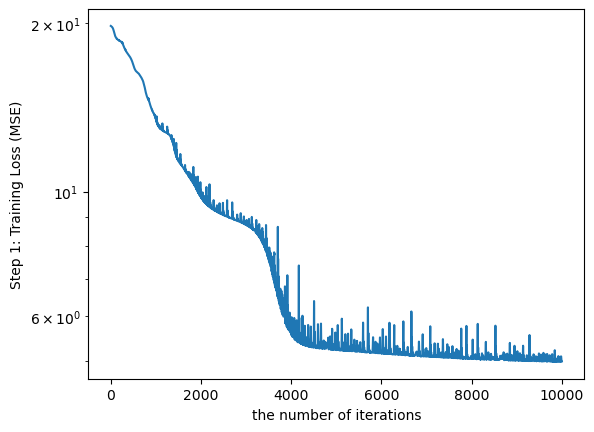

In [14]:
plt.figure()
plt.semilogy(log_loss)
plt.xlabel('the number of iterations')
plt.ylabel('Step 1: Training Loss (MSE)')
plt.show()

In [15]:
# L-BFGS optimizer configuration and run

# Initialize the L-BFGS optimizer using jaxopt
# Parameters:
# - fun: The function to minimize, in this case, 'loss_step1' which computes the loss.
# - value_and_grad=False: Indicates that we are only interested in the function value (not the gradient, as L-BFGS computes it internally).
# - maxiter: Maximum number of iterations for the L-BFGS optimization, set from the training config.
# - history_size: The number of previous iterations used to approximate the Hessian matrix for the optimizer.
# - verbose=True: Enables verbose output to display progress during optimization.
opt_lbfgs = jaxopt.LBFGS(
    fun=loss_step1, 
    value_and_grad=False, 
    maxiter=tr_config["maxiter_lbfgs"], 
    history_size=10, 
    verbose=True
)

# Run the L-BFGS optimization starting from the previously optimized parameters ('params_opt').
# The optimization process will attempt to further minimize the loss function.
res = opt_lbfgs.run(params_opt)

# Unpack the optimized parameters and the state of the optimizer after the run
params_opt, state = res


/home/houtlaw/.conda/envs/houtlaw/lib/python3.12/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/houtlaw/.conda/envs/houtlaw/lib/python3.12/site-packages/jax/_src/core.py:700: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 2453.05126953125 Stepsize:1.0  Decrease Error:2453.05126953125  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): 2124.545166015625 Stepsize:0.48947659134864807  Decrease Error:2124.545166015625  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 3 Minimum Decrease & Curvature Errors (stop. crit.): 1581.1339111328125 Stepsize:0.19696897268295288  Decrease Error:1581.1339111328125  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 4 Minimum Decrease & Curvature Errors (stop. crit.): 1913.0931396484375 Stepsize:0.07909718155860901  Decrease Error:1913.0931396484375  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 5 Minimum Decrease & Curvature Errors (stop. crit.): 2046.7646484375 Stepsize:0.02692500501871109  Decrease Error:2046.7646484375  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 6 Minimum Decrease & Curvatu

In [16]:
# Unpack the optimized parameters
params_trk, params_A = params_opt  # 'params_opt' contains the final optimized parameters for the trunk network and 'A'

# Compute the matrix for the trunk network
# vmap applies the NN_trk (trunk network) function to each row of 'trk_sensor_pts' in parallel
# This generates the output of the trunk network for all sensor points
# A column of ones is concatenated to this output to form the matrix 'trk_MAT1'
# Shape of 'trk_MAT1': (number of sensors, trunk network output + 1)
trk_MAT1 = np.concatenate(
    [vmap(lambda x: NN_trk(params_trk, x, T_act_fn), (0))(trk_sensor_pts),  # Apply trunk network to sensor points
     jnp.ones([tr_config["trunk_sensor"], 1])],  # Append a column of ones for bias
    axis=1  # Concatenate along the second axis (columns)
)

# Solve the least squares problem to find the updated 'A' parameters
# scipy.linalg.lstsq solves the equation trk_MAT1 @ params_A = trk_targets to minimize the squared error
# This finds the best-fitting 'params_A' such that the trunk network output matches the targets
params_A = scipy.linalg.lstsq(trk_MAT1, trk_targets)[0]  # Least squares solution

# Perform QR decomposition of the matrix 'trk_MAT1'
# This decomposes 'trk_MAT1' into an orthogonal matrix 'q_st' and an upper triangular matrix 'r_st'
q_st, r_st = scipy.linalg.qr(trk_MAT1, mode='economic')  # 'economic' mode returns the reduced form of the matrices

# Compute the target 'A_target' by multiplying 'r_st' with the least squares solution for 'params_A'
A_target = r_st @ params_A  # Target value for 'A' based on the QR decomposition


In [17]:
# save : params_trk, A_target (must save) | In Step 2, Branch should learn A_target
# save : trk_MAT1, params_A   (optional)

In [18]:
trk_MAT1.shape

(2881, 13)

In [19]:
A_target

array([[-163.83917509,  129.56442581, -126.28992578, ...,  128.14512952,
         163.63542641,   76.21398624],
       [-122.28160624,   67.434605  ,  -52.36697991, ...,   72.70806846,
          94.26924256,   30.75417994],
       [ -18.85685649, -112.29567726,  107.44422857, ..., -118.54973894,
         -47.24615689, -141.11772026],
       ...,
       [  22.87765723,   -4.18500237,   12.04857988, ...,   -9.94921597,
         -24.14498136,    2.66997755],
       [  18.89651585,  -40.6944576 ,   24.77186087, ...,  -52.72140627,
         -18.21514646,  -49.67483588],
       [   3.02632284,   -3.18695087,    9.55690219, ...,   -1.77414842,
          -5.86701245,    1.57109138]])

In [20]:
params_A

array([[  866971.94061881, -1416836.43144928,  1892218.6074222 , ...,
        -1517237.25593542, -1234508.19323245,  -991172.09913422],
       [ 1208708.79233081, -2449649.64724545,  1841935.1128109 , ...,
        -3065189.72089676, -1300966.89418521, -2738735.39722928],
       [  879319.23844518, -1709120.29469391,  1462464.88770092, ...,
        -2083759.18391742, -1011072.54897195, -1783659.36346398],
       ...,
       [  515682.60632857, -1141879.28886438,   623442.40916159, ...,
        -1501502.48949931,  -469339.77928864, -1445241.52169293],
       [  400694.15022676,  -871038.28557057,   511639.88314259, ...,
        -1134212.79838809,  -379048.26926186, -1076583.31643769],
       [   20438.6531502 ,   -21523.47478453,    64543.7447109 , ...,
          -11981.93520884,   -39623.60880469,    10610.5638793 ]])

In [21]:
q_st.shape

(2881, 13)